### Importar librerias y cargue de datos

In [1]:
import pandas as pd
from scipy import stats as st
import plotly.express as px
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import levene, ttest_ind, chi2_contingency, stats, norm, mannwhitneyu
import datetime as dt

In [2]:
df = pd.read_csv('/datasets/logs_exp_us.csv', sep="\t")

## Abrir el archivo de datos y leer la información general

### Acceso y verificación de los datos

In [3]:
#Verificación del DF
display(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
# Información DF
print(df.describe(),"\n\n\n")
print(df.info())

       DeviceIDHash  EventTimestamp          ExpId
count  2.441260e+05    2.441260e+05  244126.000000
mean   4.627568e+18    1.564914e+09     247.022296
std    2.642425e+18    1.771343e+05       0.824434
min    6.888747e+15    1.564030e+09     246.000000
25%    2.372212e+18    1.564757e+09     246.000000
50%    4.623192e+18    1.564919e+09     247.000000
75%    6.932517e+18    1.565075e+09     248.000000
max    9.222603e+18    1.565213e+09     248.000000 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


## Preparar los datos para el análisis

In [5]:
df.columns = ['event', 'uid', 'timestamp', 'group']

In [6]:
df['event'] = df['event'].astype('category')
df['group'] = df['group'].astype('category')
df['uid'] = df['uid'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [7]:
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

In [8]:
missing_values = df.isnull().sum()
missing_values

event        0
uid          0
timestamp    0
group        0
date         0
hour         0
dtype: int64

In [9]:
display(df)

,event,uid,timestamp,group,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21


#### ***Conclusiones y comentarios:***
En primera instancia, se observa que la base se encuentra sin registros anómalos o ausentes. Simplemente, se lleva a cabo un serie de ajustes, como modificar el tipo de dato, para que los resultados sean prolijos.

## Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [10]:
total_events = len(df["event"])

print('Total de eventos:', total_events)

Total de eventos: 244126


### ¿Cuántos usuarios hay en los registros?

In [11]:
unique_users = df['uid'].nunique()

print('Total de usuarios:', unique_users)

Total de usuarios: 7551


### ¿Cuál es el promedio de eventos por usuario?

In [12]:
#Promedio de eventos por usuario

average_events_per_user = round(total_events / unique_users, 2)
average_events_per_user

32.33

### ¿Cuántos usuarios y registros hay en los registros por evento? ¿Cuál es el promedio?

In [13]:
#Cálculo del número de eventos y usuarios únicos por tipo de evento
event_per_user = df.groupby('event', as_index=False)['uid'].agg({'dt':'count', 'uid':'nunique'})
event_per_user.columns = ['event', 'total_events', 'uid']

event_per_user['event_per_user'] = round(event_per_user['total_events']/df['uid'].nunique(), 2)

event_per_user.sort_values(by='event_per_user', ascending=False)

,event,total_events,uid,event_per_user
1,MainScreenAppear,119205,7439,15.79
2,OffersScreenAppear,46825,4613,6.20
0,CartScreenAppear,42731,3749,5.66
3,PaymentScreenSuccessful,34313,3547,4.54
4,Tutorial,1052,847,0.14


#### 1. ¿Qué periodo de tiempo cubren los datos? (Fecha máxima y mínima).
#### 2. ¿Existe una igualdad para los datos completos para todo el periodo?   
#### 3. ¿Qué periodo representan realmente los datos?

In [14]:
#Identificación del rango de fechas del conjunto de eventos
min_date = df['date'].min()
max_date = df['date'].max()
print('La fecha minima es: ', min_date)
print()
print('La fecha máxima es: ', max_date)


La fecha minima es:  2019-07-25

La fecha máxima es:  2019-08-07


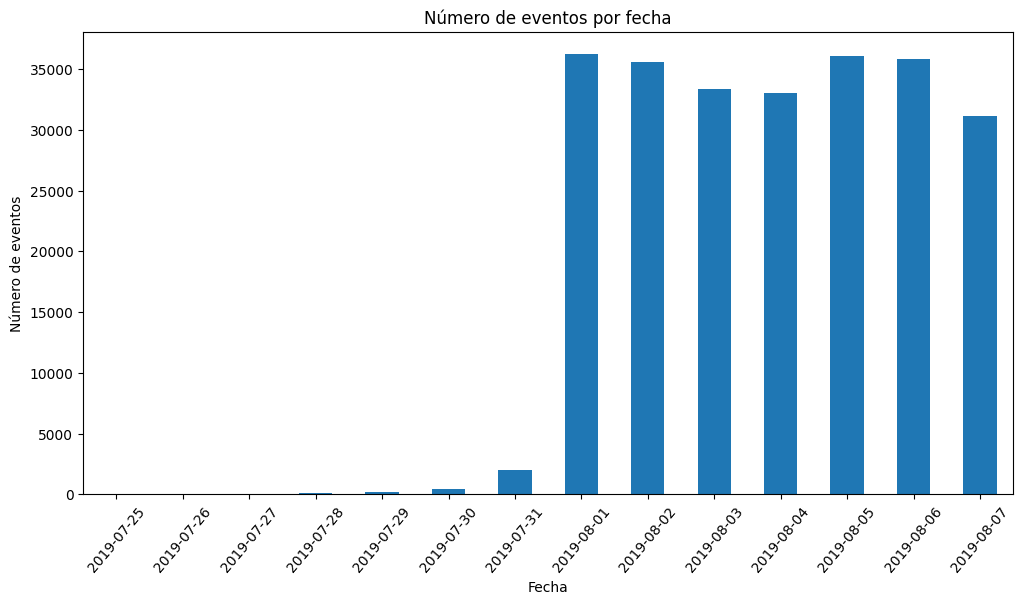

In [15]:
#Visualización de la frecuencia de eventos por fecha
plt.figure(figsize=(12, 6))
df['date'].value_counts().sort_index().plot(kind='bar')
plt.title('Número de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=50)
plt.show()


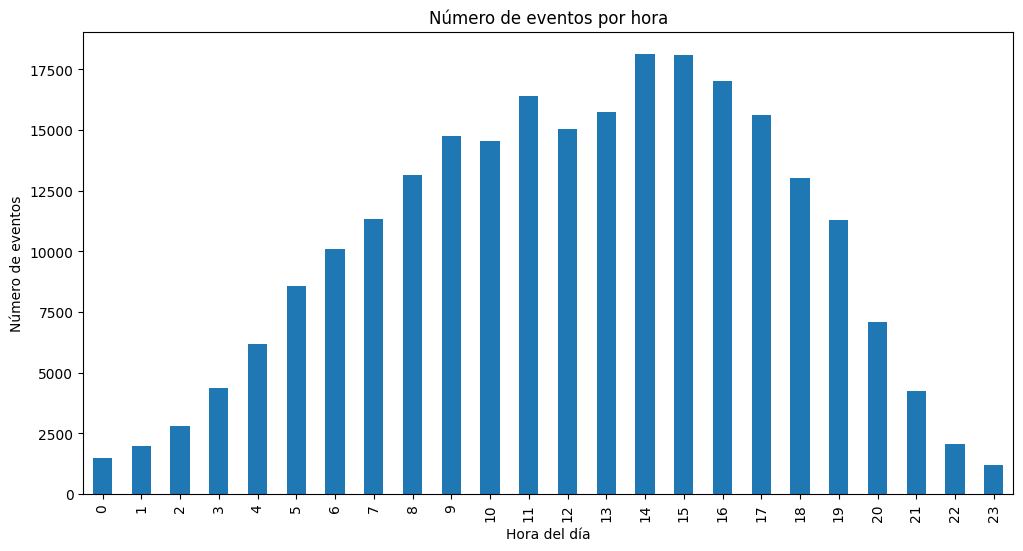

In [16]:
#Distribución de eventos a lo largo del día
plt.figure(figsize=(12, 6))
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Número de eventos por hora')
plt.xlabel('Hora del día')
plt.ylabel('Número de eventos')
plt.show()

In [17]:
# Valores tomados desde 01-08-2019 al 07-08-2019
df_clean = df[df['date'] >= pd.to_datetime('2019-08-01').date()]
display(df_clean)

,event,uid,timestamp,group,date,hour
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,0
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,0
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,0
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,0
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,0
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21


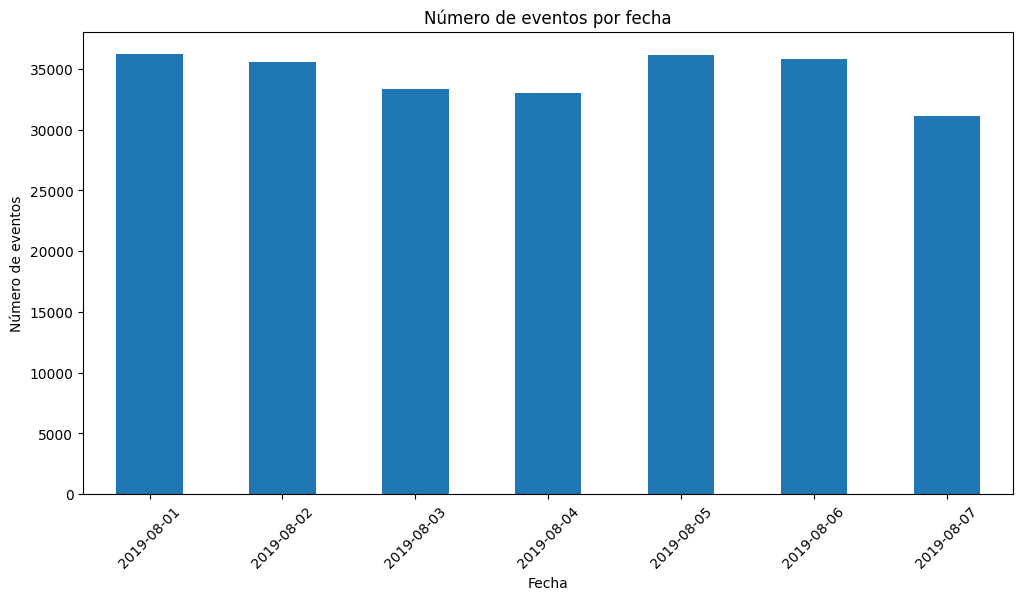

In [18]:
#Visualización de la frecuencia de eventos por fecha (2019-08-01 a 2019-08-07)
plt.figure(figsize=(12, 6))
df_clean['date'].value_counts().sort_index().plot(kind='bar')
plt.title('Número de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()

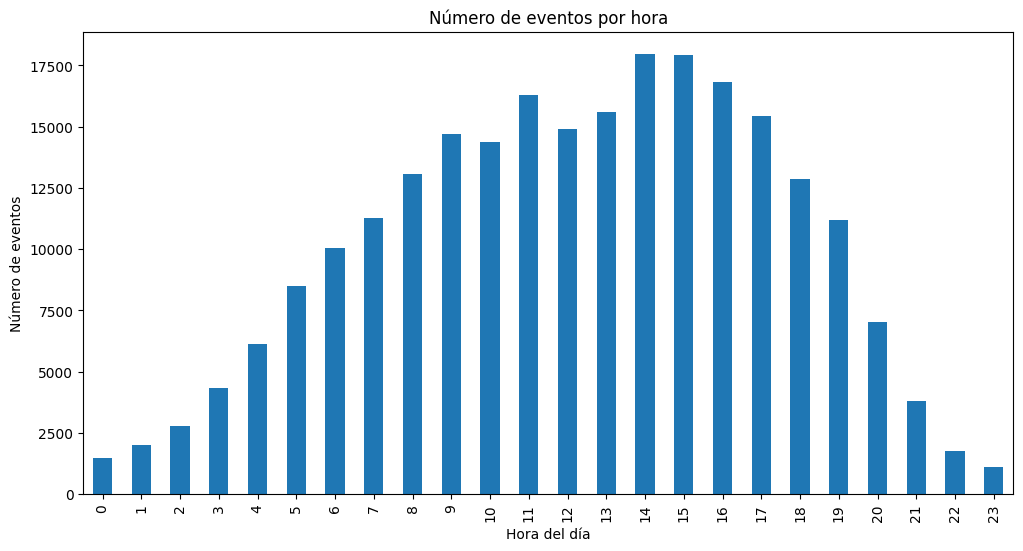

In [19]:
#Distribución de eventos a lo largo del día (2019-08-01 a 2019-08-07)
plt.figure(figsize=(12, 6))
df_clean['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Número de eventos por hora')
plt.xlabel('Hora del día')
plt.ylabel('Número de eventos')
plt.show()

### ¿Se perdieron muchos eventos y usuarios al excluir los datos más antiguos?

In [20]:
# Comparación entre el dataset original y el dataset filtrado
total_events_before = len(df)
total_events_after = len(df_clean)

total_users_before = df['uid'].nunique()
total_users_after = df_clean['uid'].nunique()

lost_events = total_events_before - total_events_after
lost_users = total_users_before - total_users_after

percent_lost_events = round(lost_events / total_events_before * 100, 2)
percent_lost_users = round(lost_users / total_users_before * 100, 2)

print(f"Eventos antes del filtro: {total_events_before}")
print(f"Eventos después del filtro: {total_events_after}")
print(f"Pérdida de eventos: {lost_events} ({percent_lost_events}%)")

print()
print(f"Usuarios antes del filtro: {total_users_before}")
print(f"Usuarios después del filtro: {total_users_after}")
print(f"Pérdida de usuarios: {lost_users} ({percent_lost_users}%)")

Eventos antes del filtro: 244126
Eventos después del filtro: 241298
Pérdida de eventos: 2828 (1.16%)

Usuarios antes del filtro: 7551
Usuarios después del filtro: 7534
Pérdida de usuarios: 17 (0.23%)


### Verificación de cantidad usuarios en los tres grupos experimentales.


In [22]:
experimental_groups = df['group'].value_counts()
experimental_groups

248    85747
246    80304
247    78075
Name: group, dtype: int64

#### ***Conclusiones y comentarios:***

Resultados generales de los datos:
* ***# total de eventos:*** 244.126 eventos
* ***# total de usuarios únicos:*** 7.551 usuarios
* ***Promedio de eventos por usuario:*** 32.33 eventos por usuario
* ***Periodo de vida de los datos:*** 25/Julio/2019 - 7/Agosto/2019.
* ***Periodo con mayor contención de datos:*** 1/Agosto/2019 - 7/Agosto/2019

Valores reportados para cada grupo partiendo de periodo de vida de los datos:
* ***Grupo 246:*** 80.304
* ***Grupo 247:*** 78.075
* ***Grupo 248:*** 85.747

Tal cómo se mencionó con anterioridad, existe un periodo con una mayor contención de los datos. Es importante definir si es estríctamente necesario trabajar con todos los periodos de la base de datos ya que se observó una diferencia mínima antes y después del filtrado por fechas de contención.

**Eventos:**
* ***Eventos antes del filtro:*** 244126
* ***Eventos después del filtro:*** 241298
* ***Pérdida de eventos:*** 2828 → (1.16%)

**Usuarios:**
* ***Usuarios antes del filtro:*** 7551
* ***Usuarios después del filtro:*** 7534
* ***Pérdida de usuarios:*** 17 → (0.23%)

De este modo, se podría disminuir el nivel de "incertidumbre" causado por fechas cuyos valores son poco significativos para este test A/A/B.

Dependiendo de los intereses y necesidades del consumidor final, sería clave definir este parámetro mencionado.

También es importante resaltar qué, para ambos casos (Filtrados y NO filtrados), existe una concentración de eventos entre las 9:00 AM y las 7:00 PM

## Estudiar el embudo de eventos

### Observación de qué eventos hay en los registros y su frecuencia de suceso → Ordenados por frecuencia.


In [23]:
#Contar la frecuencia de cada evento y ordenarlos por la frecuencia
event_frequency = df['event'].value_counts()
print(event_frequency)

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event, dtype: int64


### 1. Encontrar la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. 
### 2. Ordenar los eventos por el número de usuarios y usuarias. 
### 3. Calcular la proporción de usuarios y usuarias que realizaron la acción al menos una vez.


In [24]:
#Cantidad de usuarios por evento
users_per_event = df.groupby('event')['uid'].nunique()
print(users_per_event)

event
CartScreenAppear           3749
MainScreenAppear           7439
OffersScreenAppear         4613
PaymentScreenSuccessful    3547
Tutorial                    847
Name: uid, dtype: int64


In [25]:
#Proporción de usuarios por evento

user_proportion_per_event = (users_per_event / unique_users *100)
print(user_proportion_per_event.round(2).astype(str) + '%')

event
CartScreenAppear           49.65%
MainScreenAppear           98.52%
OffersScreenAppear         61.09%
PaymentScreenSuccessful    46.97%
Tutorial                   11.22%
Name: uid, dtype: object


#### ***Conclusiones y comentarios:***

Resultados generales de los datos:

**1.** *Frecuencia de cada uno de los eventos:*

* ***MainScreenAppear:*** 119.205
* ***OffersScreenAppear:*** 46.825
* ***CartScreenAppear:*** 42.731
* ***PaymentScreenSuccessful:*** 34.313
* ***Tutorial:*** 1.052

**2.** *Cantidad de usuarios de cada uno de los eventos:*
* ***MainScreenAppear:*** 7.439
* ***OffersScreenAppear:*** 4.613
* ***CartScreenAppear***: 3.749
* ***PaymentScreenSuccessful:*** 3.547
* ***Tutorial:*** 847

**3.** *Proporción de usuarios de cada uno de los eventos:*
* ***MainScreenAppear:*** 98.52%
* ***OffersScreenAppear:*** 61.09%
* ***CartScreenAppear:*** 49.65%
* ***PaymentScreenSuccessful:*** 46.97%
* ***Tutorial:*** 11.22%


En resúmen, se puede apreciar un flujo de usuarios bastante coherente, a simple vista, se puede ver una buena coversión relativa desde la pantalla principal hasta el momento de generar el pago.

Es importante tener presente el bajo uso del tutorial y la pérdida gradual de usuarios en las etapas intermedias (OffersScreenAppear & CartScreenAppear). Esto podría indicar que, estos segmentos del embudo, requieren atención ya que se podría mejorar u optimizar la experiencia del usuario.

### 1. ¿En qué orden ocurrieron las acciones? 
### 2. ¿Todas son parte de una sola secuencia?


In [26]:
event_sequence = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

In [27]:
#Calcular la cantidad de usuarios que completan cada etapa

user_counts = df.groupby('event')['uid'].nunique().reindex(event_sequence)
print(user_counts)

event
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: uid, dtype: int64


### Utilizar el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente.

In [28]:
# Calcular tasas de conversión entre etapas consecutivas
conversion_rates = []
for i in range(len(user_counts) - 1):
    conversion_rate = user_counts[i + 1] / user_counts[i]
    conversion_rates.append(conversion_rate)

# Crear un DataFrame con resultados legibles
funnel_conversion = pd.DataFrame({
    'De → A': [f"{event_sequence[i]} → {event_sequence[i + 1]}" for i in range(len(conversion_rates))],
    'Usuarios Etapa Anterior': user_counts.values[:-1],
    'Usuarios Etapa Actual': user_counts.values[1:],
    'Tasa de Conversión (%)': (np.array(conversion_rates) * 100).round(2)
})

display(funnel_conversion)

,De → A,Usuarios Etapa Anterior,Usuarios Etapa Actual,Tasa de Conversión (%)
0,MainScreenAppear → OffersScreenAppear,7439,4613,62.01
1,OffersScreenAppear → CartScreenAppear,4613,3749,81.27
2,CartScreenAppear → PaymentScreenSuccessful,3749,3547,94.61
3,PaymentScreenSuccessful → Tutorial,3547,847,23.88


### ¿En qué etapa pierdes más usuarios?

In [29]:
funnel_conversion['Usuarios Perdidos'] = (
    funnel_conversion['Usuarios Etapa Anterior'] - funnel_conversion['Usuarios Etapa Actual']
)

# % de pérdida
funnel_conversion['Pérdida (%)'] = (
    (funnel_conversion['Usuarios Perdidos'] / funnel_conversion['Usuarios Etapa Anterior']) * 100
).round(2)

display(funnel_conversion)

,De → A,Usuarios Etapa Anterior,Usuarios Etapa Actual,Tasa de Conversión (%),Usuarios Perdidos,Pérdida (%)
0,MainScreenAppear → OffersScreenAppear,7439,4613,62.01,2826,37.99
1,OffersScreenAppear → CartScreenAppear,4613,3749,81.27,864,18.73
2,CartScreenAppear → PaymentScreenSuccessful,3749,3547,94.61,202,5.39
3,PaymentScreenSuccessful → Tutorial,3547,847,23.88,2700,76.12


### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [208]:
# Calcular cuántos usuarios participaron en cada evento
user_counts2 = df[df['event'].isin(event_sequence)].groupby('event')['uid'].nunique().reindex(event_sequence)

# Calcular el porcentaje de usuarios que llegan al final del embudo (pago)
users_start = user_counts2.iloc[0]  # usuarios que comenzaron (MainScreenAppear)
user_payment = user_counts2.loc['PaymentScreenSuccessful']  # usuarios que completaron pago

final_percentage = round((user_payment / users_start) * 100, 2)

print(f"Usuarios que iniciaron: {users_start}")
print(f"Usuarios que completaron el pago: {user_payment}")
print(f"Porcentaje que hizo todo el recorrido: {final_percentage}%")

Usuarios que iniciaron: 7439
Usuarios que completaron el pago: 3547
Porcentaje que hizo todo el recorrido: 47.68%


#### ***Conclusiones y comentarios:***

Resultados generales de los datos:

**1.** *Cantidad de usuarios que experimentan cada etapa del embudo:*

* ***MainScreenAppear → OffersScreenAppear:*** 7.439 (CR: 62%)
* ***OffersScreenAppear → CartScreenAppear*** 4.613 (CR: 81%)
* ***CartScreenAppear → PaymentScreenSuccessful:*** 3.749 (CR: 95%) ✅
* ***PaymentScreenSuccessful → Tutorial:*** 3.547 (CR: 24%)

**2.** *Pérdida de usuarios de cada uno de los eventos:*
* ***MainScreenAppear → OffersScreenAppear::*** 2.826 (Pérdida: 38%) ❌
* ***OffersScreenAppear → CartScreenAppea:*** 864 (Pérdida: 19%)
* ***CartScreenAppear → PaymentScreenSuccessful:***: 202 (Pérdida: 5%)
* ***PaymentScreenSuccessful → Tutorial:*** 2.700 (Pérdida: 76%) 🚨

Los procesos arrojan un resultado favorable frente al desempeño en la conversión desde el momento 0 hasta el proceso de pago (47.68%), pero también se destaca una clara necesidad de optimizar la etapa de ofertas requiere optimización para reducir la pérdida del 38%.

Posteriormente, sería bueno considerar la idea de rediseñar/reemplazar o buscar la forma de impulsar el tutorial ¿Por qué? Porque es evidente que no aporta valor para la mayor parte de los usuarios que generan una compra. 


## Estudiar los resultados del experimento

### ¿Cuántos usuarios hay en cada grupo?

In [209]:
users_per_group = df.groupby('group')['uid'].nunique()

print(users_per_group)

group
246    2489
247    2520
248    2542
Name: uid, dtype: int64


### Observar si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [210]:
#Filtrar los grupos A/A
group_246 = df[df['group'] == 246]
group_247 = df[df['group'] == 247]
group_248 = df[df['group'] == 248]

# Usuarios únicos por grupo
users_246 = group_246['uid'].nunique()
users_247 = group_247['uid'].nunique()

pay_246 = group_246[group_246['event'] == 'PaymentScreenSuccessful']['uid'].nunique()
pay_247 = group_247[group_247['event'] == 'PaymentScreenSuccessful']['uid'].nunique()

print(f"Grupo 246 → {pay_246} de {users_246} usuarios completaron pago ({pay_246/users_246:.2%})")
print(f"Grupo 247 → {pay_247} de {users_247} usuarios completaron pago ({pay_247/users_247:.2%})")

Grupo 246 → 1202 de 2489 usuarios completaron pago (48.29%)
Grupo 247 → 1160 de 2520 usuarios completaron pago (46.03%)


In [211]:
#Creación muestras binarias: 1 = usuario que pagó, 0 = usuario que no pagó
sample_246 = group_246.groupby('uid')['event'].apply(lambda x: int('PaymentScreenSuccessful' in x.values))
sample_247 = group_247.groupby('uid')['event'].apply(lambda x: int('PaymentScreenSuccessful' in x.values))

# Aplicar prueba estadística
alpha = 0.05
results = mannwhitneyu(sample_246, sample_247)

print("p-value:", round(results.pvalue, 4))

if results.pvalue < alpha:
    print("Se rechaza la hipótesis nula: existe una diferencia estadísticamente significativa entre los grupos.")
else:
    print("No se rechaza la hipótesis nula: no hay diferencias significativas entre los grupos A/A.")

p-value: 0.1091
No se rechaza la hipótesis nula: no hay diferencias significativas entre los grupos A/A.


#### ***Conclusiones y comentarios:***

Los grupos A/A, correspondientes a los grupos 246 y 247, se comportan de manera equivalente.

Esto significa que el sistema de experimentación funciona correctamente y que los futuros tests A/B pueden realizarse con confianza, ya que no hay sesgos ni errores sistemáticos en la medición.


### Análisis de eventos y validación de grupos

Seleccionar el evento más popular y, para cada grupo de control, calcular:
- La cantidad de usuarios que realizaron el evento.
- La proporción de usuarios respecto al total del grupo.

Evaluar si la diferencia entre los grupos es estadísticamente significativa.
Repetir el procedimiento para todos los eventos utilizando una función reutilizable.

Finalmente, verificar si los grupos fueron divididos correctamente.

In [212]:
events = df['event'].unique()

def compare_groups(event_name):
    group_246 = df[df['group'] == 246]
    group_247 = df[df['group'] == 247]
    
    users_246 = group_246['uid'].nunique()
    users_247 = group_247['uid'].nunique()
    
    event_246 = group_246[group_246['event'] == event_name]['uid'].nunique()
    event_247 = group_247[group_247['event'] == event_name]['uid'].nunique()
    
    p1 = event_246 / users_246
    p2 = event_247 / users_247

    p_combined = (event_246 + event_247) / (users_246 + users_247)
    z_score = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1/users_246 + 1/users_247))
    p_value = 2 * (1 - norm.cdf(abs(z_score)))  # bilateral
    
    return {
        'Evento': event_name,
        'Usuarios 246': event_246,
        'Usuarios 247': event_247,
        'Proporción 246 (%)': round(p1 * 100, 2),
        'Proporción 247 (%)': round(p2 * 100, 2),
        'p_value': round(p_value, 4),
        'Significativo': 'NO es significativo' if p_value > 0.05 else 'SI es significativo'
    }

results = pd.DataFrame([compare_groups(e) for e in events])
display(results)

,Evento,Usuarios 246,Usuarios 247,Proporción 246 (%),Proporción 247 (%),p_value,Significativo
0,MainScreenAppear,2456,2482,98.67,98.49,0.5857,NO es significativo
1,PaymentScreenSuccessful,1202,1160,48.29,46.03,0.1090,NO es significativo
2,CartScreenAppear,1270,1240,51.02,49.21,0.1982,NO es significativo
3,OffersScreenAppear,1545,1530,62.07,60.71,0.3233,NO es significativo
4,Tutorial,279,286,11.21,11.35,0.8757,NO es significativo


#### ***Conclusiones y comentarios:***

Los resultados del test A/A muestran que no existen diferencias estadísticamente significativas entre los grupos de control en ninguno de los eventos analizados, lo cual confirma una correcta aleatorización y consistencia en las mediciones del experimento.

### Análisis del grupo con fuentes alteradas

Repetir el análisis para el grupo con fuentes alteradas, calculando para cada evento:
- El número de usuarios que realizaron la acción.
- La proporción de usuarios dentro del grupo.

Comparar los resultados:
- Contra cada uno de los grupos de control de forma individual.
- Contra los resultados combinados de los grupos de control.

A partir de estas comparaciones, extraer conclusiones sobre el impacto de las fuentes alteradas en el comportamiento de los usuarios.

In [213]:
# Combinar los grupos de control
control = df[df['group'].isin([246, 247])]
exp = df[df['group'] == 248]

def compare_groups(event_name, group_a, group_b):
    a = df[df['group'] == group_a]
    b = df[df['group'] == group_b]

    users_a = a['uid'].nunique()
    users_b = b['uid'].nunique()

    event_a = a[a['event'] == event_name]['uid'].nunique()
    event_b = b[b['event'] == event_name]['uid'].nunique()

    p1 = event_a / users_a
    p2 = event_b / users_b

    p_combined = (event_a + event_b) / (users_a + users_b)
    z_score = (p1 - p2) / ((p_combined * (1 - p_combined) * (1/users_a + 1/users_b)) ** 0.5)
    p_value = 2 * (1 - norm.cdf(abs(z_score)))  # bilateral

    return {
        'Evento': event_name,
        f'Proporción grupo {group_a}': f"{p1:.2%}",
        f'Proporción grupo {group_b}': f"{p2:.2%}",
        'p-value': round(p_value, 4),
        'Significativo': 'SI es significativo' if p_value < 0.05 else 'NO es significativo'
    }

# Comparar grupo 248 con cada control
results_248_246 = pd.DataFrame([compare_groups(e, 248, 246) for e in events])
results_248_247 = pd.DataFrame([compare_groups(e, 248, 247) for e in events])

# Comparar grupo 248 con el grupo de control combinado
def compare_combined(event_name):
    users_control = control['uid'].nunique()
    users_exp = exp['uid'].nunique()

    event_control = control[control['event'] == event_name]['uid'].nunique()
    event_exp = exp[exp['event'] == event_name]['uid'].nunique()

    p1 = event_control / users_control
    p2 = event_exp / users_exp

    p_combined = (event_control + event_exp) / (users_control + users_exp)
    z_score = (p1 - p2) / ((p_combined * (1 - p_combined) * (1/users_control + 1/users_exp)) ** 0.5)
    p_value = 2 * (1 - norm.cdf(abs(z_score)))  # bilateral

    return {
        'Evento': event_name,
        'Proporción Control': f"{p1:.2%}",
        'Proporción Experimental (248)': f"{p2:.2%}",
        'p-value': round(p_value, 4),
        'Significativo': 'SI es significativo' if p_value < 0.05 else 'NO es significativo'
    }

results_248_control = pd.DataFrame([compare_combined(e) for e in events])

display(results_248_246)
display(results_248_247)
display(results_248_control)

,Evento,Proporción grupo 248,Proporción grupo 246,p-value,Significativo
0,MainScreenAppear,98.39%,98.67%,0.3977,NO es significativo
1,PaymentScreenSuccessful,46.62%,48.29%,0.2340,NO es significativo
2,CartScreenAppear,48.74%,51.02%,0.1053,NO es significativo
3,OffersScreenAppear,60.50%,62.07%,0.2532,NO es significativo
4,Tutorial,11.09%,11.21%,0.8963,NO es significativo


,Evento,Proporción grupo 248,Proporción grupo 247,p-value,Significativo
0,MainScreenAppear,98.39%,98.49%,0.7632,NO es significativo
1,PaymentScreenSuccessful,46.62%,46.03%,0.6764,NO es significativo
2,CartScreenAppear,48.74%,49.21%,0.7406,NO es significativo
3,OffersScreenAppear,60.50%,60.71%,0.8781,NO es significativo
4,Tutorial,11.09%,11.35%,0.7733,NO es significativo


,Evento,Proporción Control,Proporción Experimental (248),p-value,Significativo
0,MainScreenAppear,98.58%,98.39%,0.5067,NO es significativo
1,PaymentScreenSuccessful,47.16%,46.62%,0.6578,NO es significativo
2,CartScreenAppear,50.11%,48.74%,0.2610,NO es significativo
3,OffersScreenAppear,61.39%,60.50%,0.4555,NO es significativo
4,Tutorial,11.28%,11.09%,0.8087,NO es significativo


#### ***Conclusiones y comentarios:***

* No hay evidencia estadísticamente significativa de que los grupos difieran entre sí, ya sea en los eventos principales o secundarios.

* Las tasas de conversión y participación por evento se mantienen prácticamente iguales (diferencias <2%).

Esto valida que:

    1. La asignación aleatoria de los usuarios a los grupos fue correcta y balanceada.

    2. El sistema de tracking y la captura de eventos funcionan de manera consistente.

    3. El grupo experimental (248) no produjo ningún cambio medible en el comportamiento de los usuarios.

### Nivel de significancia y control del error estadístico

Para las pruebas de hipótesis realizadas se estableció un nivel de significancia de 0.1. Esto implica que existe un 10 % de probabilidad de cometer un error tipo I, es decir, rechazar una hipótesis nula cuando en realidad es verdadera.

Dado el número de pruebas estadísticas realizadas, este nivel de significancia incrementa el riesgo de obtener resultados falsos positivos. En promedio, uno de cada diez resultados podría ser estadísticamente significativo por azar.

Por esta razón, un nivel de significancia más conservador, como 0.05, resulta más apropiado para este análisis. Al ajustar el nivel de significancia y repetir las pruebas, se puede verificar si las conclusiones se mantienen, lo que permite evaluar la robustez de los resultados obtenidos.



#### ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente?
Nivel de significancia α = 0.05 (5%) → "Se acepta que hay una diferencia real entre grupos si la probabilidad de error es menor al 5%"

#### ¿Cuántas pruebas de hipótesis se llevaron a cabo?
Se llevaron a cabo 5 pruebas estadísticas comparativas. Estas 5 pruebas estadísticas corresponden a los 5 tipos de eventos reportados en la base de datos:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful
5. Tutorial

Además, se llevó a cabo 3 comparaciones:
1. 248 vs 246
2. 248 vs 247
3. 248 vs control combinado

En resúmen, se realización 15 pruebas (5 eventos x 3 comparaciones)

#### Riesgo de falsos positivos

Pada prueba tiene una probabilidad α de ser “falso positivo” (rechazar H0 cuando es cierta).

Si α = 0.05 (5%) y se lleva a cabo 15 pruebas: En promedio, 0.05 × 15 = 0.75 pruebas podrían ser falsos positivos (≈ 1 de cada 15 resultados).

Si se usara un α = 0.1 (10%) y se lleva a cabo 15 pruebas: 1.5 resultados falsos positivos esperados de 15 pruebas.

#### ¿Qué nivel de significancia se debería implementar?
1. *Analisis exploratorio:* Se debería usar α = 0.1 (Permite detectar posibles tendencias o diferencias).
2. *Análisis de test A/B:* (Es el estándar estadístico para reducir falsos positivos).

#### ***Conclusiones y comentarios:***
Para este análisis, se estableció inicialmente un nivel de significancia de α = 0.05 (5%), lo que implica que existe un 5% de probabilidad de detectar una diferencia que en realidad no existe.

Se realizaron 15 pruebas de hipótesis (5 eventos x 3 comparaciones entre grupos).

Dado que con un nivel de significancia de 0.1 uno de cada 10 resultados podría ser falso, se considera más adecuado mantener α = 0.05 para asegurar resultados estadísticamente robustos.

Al aplicar la modificación de α = 0.01 (1%), se reduce la probabilidad de falsos positivos, pero aumenta el riesgo de NO detectar diferencias reales, lo que se le denomina falsos negativos.